<a href="https://colab.research.google.com/github/christophergaughan/medical-imaging-pytorch/blob/main/07_Lung_Tumor_Segmentation_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung Tumor Segmentation from CT Scans

**What you'll learn:**
1. **CT vs MRI** — Fixed Hounsfield units, different normalization
2. **Severe Class Imbalance** — Tumors are tiny; most pixels are background
3. **Weighted Sampling** — Oversample slices containing tumors
4. **BCE vs Dice Loss** — When to use which

**Clinical relevance:**
- Lung cancer is the leading cause of cancer death worldwide
- Early detection via CT screening saves lives
- Automated segmentation assists radiologists in treatment planning

**Dataset:** [Medical Segmentation Decathlon - Task06_Lung](http://medicaldecathlon.com/)

**GPU Required:** Yes

---

## Table of Contents

1. [Part 1: Data Preprocessing](#part1) — CT normalization, slicing
2. [Part 2: Dataset & Augmentation](#part2) — Handling class imbalance
3. [Part 3: U-Net Architecture](#part3) — Same as atrium (it works!)
4. [Part 4: Training & Evaluation](#part4) — BCE loss, weighted sampling

---

## Setup

In [1]:
# Install dependencies
!pip install nibabel albumentations celluloid pytorch-lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.3 MB/s eta 0:00:00


In [2]:
# Mount Google Drive (if using Drive for output)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract the dataset (if not already extracted)
# from pathlib import Path

# TAR_PATH = Path("/content/Task06_Lung.tar")
# EXTRACT_PATH = Path("/content/Task06_Lung")

# if not EXTRACT_PATH.exists() and TAR_PATH.exists():
#     print("Extracting Task06_Lung.tar...")
#     !tar -xf {TAR_PATH} -C /content/
#     print("Done!")
# else:
#     print(f"Data ready at {EXTRACT_PATH}")

# !ls /content/Task06_Lung/

In [4]:
# Core imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

# Medical imaging
import nibabel as nib

# Deep learning
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Augmentation
import albumentations as A

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [5]:
# Set paths
DATA_ROOT = Path("/content/drive/MyDrive/AI_Medical_Images/07-LungTumor-Segmentation/Task06_Lung")
IMAGES_DIR = DATA_ROOT / "imagesTr"
LABELS_DIR = DATA_ROOT / "labelsTr"
PROCESSED_DIR = Path("/content/Preprocessed_Lung")

print(f"Images: {len(list(IMAGES_DIR.glob('*.nii.gz')))} subjects")
print(f"Labels: {len(list(LABELS_DIR.glob('*.nii.gz')))} subjects")

Images: 126 subjects
Labels: 126 subjects


---
<a id='part1'></a>
# Part 1: Data Preprocessing

## CT vs MRI: Key Differences

| Property | MRI (Atrium) | CT (Lung) |
|----------|--------------|----------|
| **Units** | Arbitrary intensity | Hounsfield Units (HU) |
| **Range** | Varies per scan | Fixed: -1000 to 3071 |
| **Normalization** | Per-subject z-score | Divide by 3071 (global) |
| **Air** | — | -1000 HU |
| **Water** | — | 0 HU |
| **Bone** | — | +1000 HU |

**Hounsfield Units** are calibrated to physical density — this is why CT normalization is simpler!

---

In [6]:
def change_img_to_label_path(path: Path) -> Path:
    """Convert image path to corresponding label path."""
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [7]:
# Load a sample subject
sample_path = sorted(IMAGES_DIR.glob("lung_*.nii.gz"))[0]
sample_label_path = change_img_to_label_path(sample_path)

print(f"CT: {sample_path.name}")
print(f"Mask: {sample_label_path.name}")

# Load NIfTI
ct_nii = nib.load(sample_path)
mask_nii = nib.load(sample_label_path)

ct = ct_nii.get_fdata()
mask = mask_nii.get_fdata().astype(np.uint8)

print(f"\nCT shape: {ct.shape}")
print(f"CT range: [{ct.min():.0f}, {ct.max():.0f}] HU")
print(f"\nMask shape: {mask.shape}")
print(f"Mask unique values: {np.unique(mask)}")
print(f"Tumor voxels: {(mask > 0).sum():,} ({100*(mask > 0).mean():.2f}%)")
print(f"\nOrientation: {nib.aff2axcodes(ct_nii.affine)}")

CT: lung_001.nii.gz
Mask: lung_001.nii.gz

CT shape: (512, 512, 304)
CT range: [-1024, 3071] HU

Mask shape: (512, 512, 304)
Mask unique values: [0 1]
Tumor voxels: 2,719 (0.00%)

Orientation: ('L', 'A', 'S')


### Visualize the CT Volume

Note how **small** the tumor is compared to the full lung volume — this is the class imbalance problem.

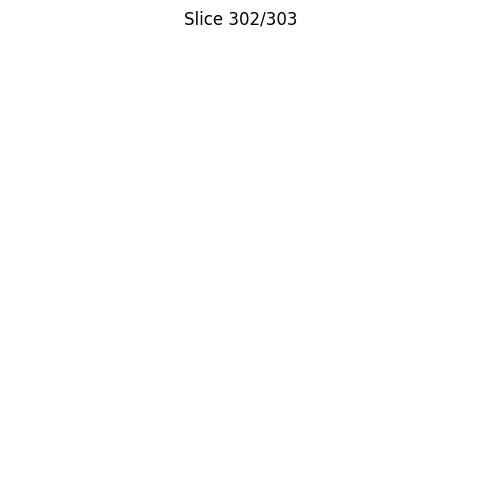

In [8]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)

# Axial view (last axis), skip every 2nd slice for speed
for i in range(0, ct.shape[2], 2):
    plt.imshow(ct[:, :, i], cmap="bone", vmin=-1000, vmax=1000)
    mask_slice = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_slice, alpha=0.5, cmap="autumn")
    plt.title(f"Slice {i}/{ct.shape[2]-1}")
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

### Preprocessing Pipeline

For lung CT:

1. **Normalize** — Divide by 3071 (CT has fixed range)
2. **Crop** — Skip first 30 slices (lower abdomen, no lungs)
3. **Resize** — 256×256 for U-Net
4. **Slice** — Save as 2D numpy files

In [9]:
def normalize_ct(volume: np.ndarray) -> np.ndarray:
    """
    Normalize CT by dividing by max HU value.

    Unlike MRI, CT has a fixed range (-1000 to 3071 HU),
    so we can use global normalization.
    """
    # Clip to valid HU range and normalize to [0, 1]
    volume = np.clip(volume, -1000, 3071)
    volume = (volume + 1000) / 4071  # Shift to 0 and divide by range
    return volume.astype(np.float32)

In [12]:
def preprocess_and_save(
    images_dir: Path,
    save_dir: Path,
    train_split: int = 57,  # 63 total, last 6 for val
    skip_slices: int = 30,  # Skip lower abdomen
    target_size: tuple = (256, 256)
):
    """
    Preprocess all CT subjects and save as 2D numpy slices.
    """
    all_files = sorted(images_dir.glob("lung_*.nii.gz"))
    print(f"Found {len(all_files)} subjects")

    for idx, ct_path in enumerate(tqdm(all_files, desc="Preprocessing")):
        # Load CT and mask
        label_path = change_img_to_label_path(ct_path)

        ct_nii = nib.load(ct_path)
        ct = ct_nii.get_fdata()
        mask = nib.load(label_path).get_fdata().astype(np.uint8)

        # Normalize CT
        ct = normalize_ct(ct)

        # Skip lower abdomen slices
        ct = ct[:, :, skip_slices:]
        mask = mask[:, :, skip_slices:]

        # Determine train/val split
        split = "train" if idx < train_split else "val"
        subject_dir = save_dir / split / str(idx)

        # Save each 2D slice
        data_dir = subject_dir / "data"
        mask_dir = subject_dir / "masks"
        data_dir.mkdir(parents=True, exist_ok=True)
        mask_dir.mkdir(parents=True, exist_ok=True)

        for slice_idx in range(ct.shape[2]):
            # Resize to target size
            ct_slice = cv2.resize(ct[:, :, slice_idx], target_size)
            mask_slice = cv2.resize(
                mask[:, :, slice_idx],
                target_size,
                interpolation=cv2.INTER_NEAREST  # Super-Critical for masks!
            )

            np.save(data_dir / f"{slice_idx}.npy", ct_slice)
            np.save(mask_dir / f"{slice_idx}.npy", mask_slice)

    print(f"\nSaved to {save_dir}")
    print(f"Train subjects: {train_split}")
    print(f"Val subjects: {len(all_files) - train_split}")

In [13]:
# Run preprocessing
if not PROCESSED_DIR.exists():
    preprocess_and_save(IMAGES_DIR, PROCESSED_DIR)
else:
    print(f"Preprocessed data already exists at {PROCESSED_DIR}")

# Count slices
train_slices = len(list((PROCESSED_DIR / "train").glob("*/data/*.npy")))
val_slices = len(list((PROCESSED_DIR / "val").glob("*/data/*.npy")))
print(f"Train slices: {train_slices}")
print(f"Val slices: {val_slices}")

Preprocessed data already exists at /content/Preprocessed_Lung
Train slices: 14484
Val slices: 1283


Found tumor in slice 201


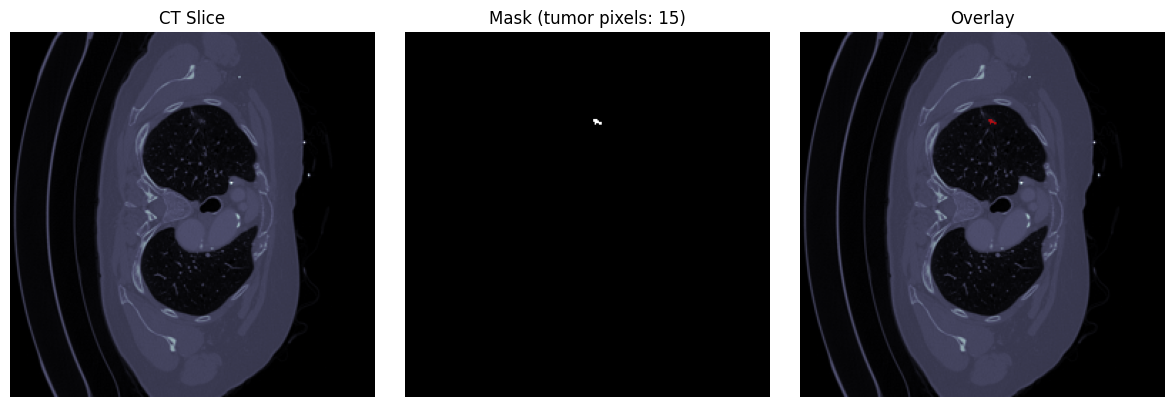

Slice shape: (256, 256)
Slice range: [0.000, 0.852]


In [15]:
# Verify preprocessing — find a slice with tumor
sample_dir = PROCESSED_DIR / "train/0"

# Find a slice with tumor (search wider range)
sample_idx = None
for i in range(0, 300):
    mask_path = sample_dir / "masks" / f"{i}.npy"
    if mask_path.exists():
        m = np.load(mask_path)
        if m.sum() > 0:
            sample_idx = i
            print(f"Found tumor in slice {i}")
            break

if sample_idx is None:
    # Try another subject
    for subj in range(1, 10):
        sample_dir = PROCESSED_DIR / f"train/{subj}"
        for i in range(0, 300):
            mask_path = sample_dir / "masks" / f"{i}.npy"
            if mask_path.exists():
                m = np.load(mask_path)
                if m.sum() > 0:
                    sample_idx = i
                    print(f"Found tumor in subject {subj}, slice {i}")
                    break
        if sample_idx is not None:
            break

if sample_idx is None:
    raise ValueError("No tumor found in any training slice!")

sample_slice = np.load(sample_dir / "data" / f"{sample_idx}.npy")
sample_mask = np.load(sample_dir / "masks" / f"{sample_idx}.npy")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_slice, cmap='bone')
axes[0].set_title('CT Slice')
axes[0].axis('off')

axes[1].imshow(sample_mask, cmap='gray')
axes[1].set_title(f'Mask (tumor pixels: {sample_mask.sum():.0f})')
axes[1].axis('off')

axes[2].imshow(sample_slice, cmap='bone')
mask_overlay = np.ma.masked_where(sample_mask == 0, sample_mask)
axes[2].imshow(mask_overlay, cmap='autumn', alpha=0.6)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Slice shape: {sample_slice.shape}")
print(f"Slice range: [{sample_slice.min():.3f}, {sample_slice.max():.3f}]")

---
<a id='part2'></a>
# Part 2: Dataset & Handling Class Imbalance

## The Problem: Tiny Tumors

Lung tumors often occupy < 1% of the image. If we train naively:
- Model learns to predict "no tumor" everywhere
- Gets 99%+ accuracy!
- ...but completely useless clinically

## Solution: Weighted Random Sampling

Oversample slices that contain tumors so the model sees them more often.

```
Without sampling: [no, no, no, no, no, no, no, no, tumor, no, no, ...]
With sampling:    [no, tumor, no, tumor, tumor, no, tumor, no, ...]
```

In [16]:
class LungDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for lung CT slices and tumor masks.
    """

    def __init__(self, root: Path, augment_params=None):
        self.all_files = self._extract_files(root)
        self.augment_params = augment_params
        print(f"Found {len(self.all_files)} slices in {root}")

    @staticmethod
    def _extract_files(root: Path) -> list:
        files = []
        for subject_dir in sorted(root.glob("*")):
            if subject_dir.is_dir():
                data_dir = subject_dir / "data"
                for slice_path in sorted(data_dir.glob("*.npy")):
                    files.append(slice_path)
        return files

    @staticmethod
    def _get_mask_path(slice_path: Path) -> Path:
        parts = list(slice_path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx: int):
        slice_path = self.all_files[idx]
        mask_path = self._get_mask_path(slice_path)

        image = np.load(slice_path).astype(np.float32)
        mask = np.load(mask_path)

        # Augment
        if self.augment_params is not None:
            augmented = self.augment_params(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add channel dimension
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return image, mask

In [17]:
# Augmentation pipeline
train_augmentation = A.Compose([
    A.Affine(
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)},
        scale=(0.85, 1.15),
        rotate=(-45, 45),
        p=1.0
    ),
    A.ElasticTransform(alpha=50, sigma=5, p=0.5),
])

In [18]:
# Create datasets
train_dataset = LungDataset(PROCESSED_DIR / "train", augment_params=train_augmentation)
val_dataset = LungDataset(PROCESSED_DIR / "val", augment_params=None)

Found 14484 slices in /content/Preprocessed_Lung/train
Found 1283 slices in /content/Preprocessed_Lung/val


### Create Weighted Sampler

In [19]:
# Build target list: does each slice contain a tumor?
print("Scanning slices for tumors (one-time operation)...")
target_list = []

for slice_path in tqdm(train_dataset.all_files):
    mask_path = train_dataset._get_mask_path(slice_path)
    mask = np.load(mask_path)
    has_tumor = 1 if np.any(mask) else 0
    target_list.append(has_tumor)

# Count classes
unique, counts = np.unique(target_list, return_counts=True)
print(f"\nClass distribution:")
print(f"  No tumor: {counts[0]} slices ({100*counts[0]/len(target_list):.1f}%)")
print(f"  Tumor:    {counts[1]} slices ({100*counts[1]/len(target_list):.1f}%)")

Scanning slices for tumors (one-time operation)...


  0%|          | 0/14484 [00:00<?, ?it/s]


Class distribution:
  No tumor: 12967 slices (89.5%)
  Tumor:    1517 slices (10.5%)


In [20]:
# Calculate class weights
# Weight tumor slices higher to balance sampling
fraction = counts[0] / counts[1]  # How much more common are non-tumor slices?
print(f"Class imbalance ratio: {fraction:.1f}x")

# Create weight for each sample
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1.0)
    else:
        weight_list.append(fraction)  # Upweight tumor slices

# Create sampler
sampler = torch.utils.data.WeightedRandomSampler(
    weights=weight_list,
    num_samples=len(weight_list),
    replacement=True
)

Class imbalance ratio: 8.5x


In [21]:
# Create data loaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler!
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No sampler for validation!
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 1811
Val batches: 161


In [22]:
# Verify sampler is working
# With proper sampling, ~50% of batch should have tumors
batch = next(iter(train_loader))
images, masks = batch
has_tumor = (masks[:, 0].sum(dim=[1, 2]) > 0).sum().item()
print(f"Batch of {BATCH_SIZE}: {has_tumor} slices have tumors ({100*has_tumor/BATCH_SIZE:.0f}%)")
print("(Should be ~50% with balanced sampling)")

Batch of 8: 3 slices have tumors (38%)
(Should be ~50% with balanced sampling)


---
<a id='part3'></a>
# Part 3: U-Net Architecture

Same architecture as atrium — U-Net generalizes well across medical imaging tasks.

In [23]:
class DoubleConv(nn.Module):
    """Double convolution block: (Conv → ReLU) × 2"""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    """U-Net for semantic segmentation."""

    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Decoder
        self.dec3 = DoubleConv(512 + 256, 256)
        self.dec2 = DoubleConv(256 + 128, 128)
        self.dec1 = DoubleConv(128 + 64, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder with skip connections
        d3 = self.dec3(torch.cat([self.upsample(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upsample(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upsample(d2), e1], dim=1))

        return self.final(d1)

---
<a id='part4'></a>
# Part 4: Training & Evaluation

## BCE vs Dice Loss

For lung tumors, **BCE (Binary Cross-Entropy) works better** than Dice:

| Loss | Pros | Cons |
|------|------|------|
| **Dice** | Directly optimizes overlap | Unstable for very small objects |
| **BCE** | Stable gradients | Class imbalance issues |

We handle class imbalance with weighted sampling, so BCE's stability wins.

In [24]:
class DiceLoss(nn.Module):
    """Dice Loss for evaluation (not training)."""

    def __init__(self, smooth: float = 1e-8):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        pred = pred.view(-1)
        mask = mask.view(-1)
        intersection = (pred * mask).sum()
        dice = (2.0 * intersection + self.smooth) / (pred.sum() + mask.sum() + self.smooth)
        return 1.0 - dice

In [25]:
class TumorSegmentation(pl.LightningModule):
    """
    PyTorch Lightning module for lung tumor segmentation.
    Uses BCE loss for training, reports Dice for evaluation.
    """

    def __init__(self, learning_rate: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = UNet()
        self.loss_fn = nn.BCEWithLogitsLoss()  # BCE for training
        self.dice_loss = DiceLoss()  # Dice for monitoring
        self.learning_rate = learning_rate

    def forward(self, x):
        return torch.sigmoid(self.model(x))

    def training_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.float()

        logits = self.model(images)  # Raw logits for BCE
        loss = self.loss_fn(logits, masks)

        # Also compute Dice for monitoring
        with torch.no_grad():
            preds = torch.sigmoid(logits)
            dice = 1 - self.dice_loss(preds, masks)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_dice', dice, prog_bar=True)

        if batch_idx % 50 == 0:
            self._log_images(images, preds, masks, 'train')

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.float()

        logits = self.model(images)
        loss = self.loss_fn(logits, masks)

        preds = torch.sigmoid(logits)
        dice = 1 - self.dice_loss(preds, masks)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice', dice, prog_bar=True)

        if batch_idx % 10 == 0:
            self._log_images(images, preds, masks, 'val')

        return loss

    def _log_images(self, images, preds, masks, name):
        preds_binary = (preds > 0.5).float()

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(images[0, 0].cpu(), cmap='bone')
        mask_gt = np.ma.masked_where(masks[0, 0].cpu() == 0, masks[0, 0].cpu())
        axes[0].imshow(mask_gt, alpha=0.6, cmap='autumn')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')

        axes[1].imshow(images[0, 0].cpu(), cmap='bone')
        mask_pred = np.ma.masked_where(preds_binary[0, 0].cpu() == 0, preds_binary[0, 0].cpu())
        axes[1].imshow(mask_pred, alpha=0.6, cmap='autumn')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

        self.logger.experiment.add_figure(name, fig, self.global_step)
        plt.close(fig)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [26]:
# Initialize model
torch.manual_seed(42)
model = TumorSegmentation(learning_rate=1e-4)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    save_top_k=3,
    filename='tumor-{epoch:02d}-{val_dice:.3f}'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    logger=TensorBoardLogger(save_dir='./logs', name='lung_tumor'),
    log_every_n_steps=5
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [27]:
# Train!
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_p

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ UNet              │  7.8 M │ train │     0 │
│ 1 │ loss_fn   │ BCEWithLogitsLoss │      0 │ train │     0 │
│ 2 │ dice_loss │ DiceLoss          │      0 │ train │     0 │
└───┴───────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 7.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.8 M                                                                                                
Total estimated model params size (MB): 31                                                                         
Modules in train mode: 48                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [28]:
# Best checkpoint
print(f"Best model: {checkpoint_callback.best_model_path}")
if checkpoint_callback.best_model_score is not None:
    print(f"Best val dice: {checkpoint_callback.best_model_score:.4f}")

Best model: ./logs/lung_tumor/version_0/checkpoints/tumor-epoch=02-val_dice=0.031.ckpt
Best val dice: 0.0310


## Evaluation

In [29]:
# Load best model
best_model_path = checkpoint_callback.best_model_path
if best_model_path:
    model = TumorSegmentation.load_from_checkpoint(best_model_path)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
# Compute Dice score on validation set
all_preds = []
all_masks = []

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        preds = model(images)
        all_preds.append(preds.cpu())
        all_masks.append(masks)

all_preds = torch.cat(all_preds)
all_masks = torch.cat(all_masks).float()

dice_loss = DiceLoss()(all_preds, all_masks)
dice_score = 1 - dice_loss.item()

print(f"\nValidation Dice Score: {dice_score:.4f}")

Evaluating:   0%|          | 0/161 [00:00<?, ?it/s]


Validation Dice Score: 0.2842


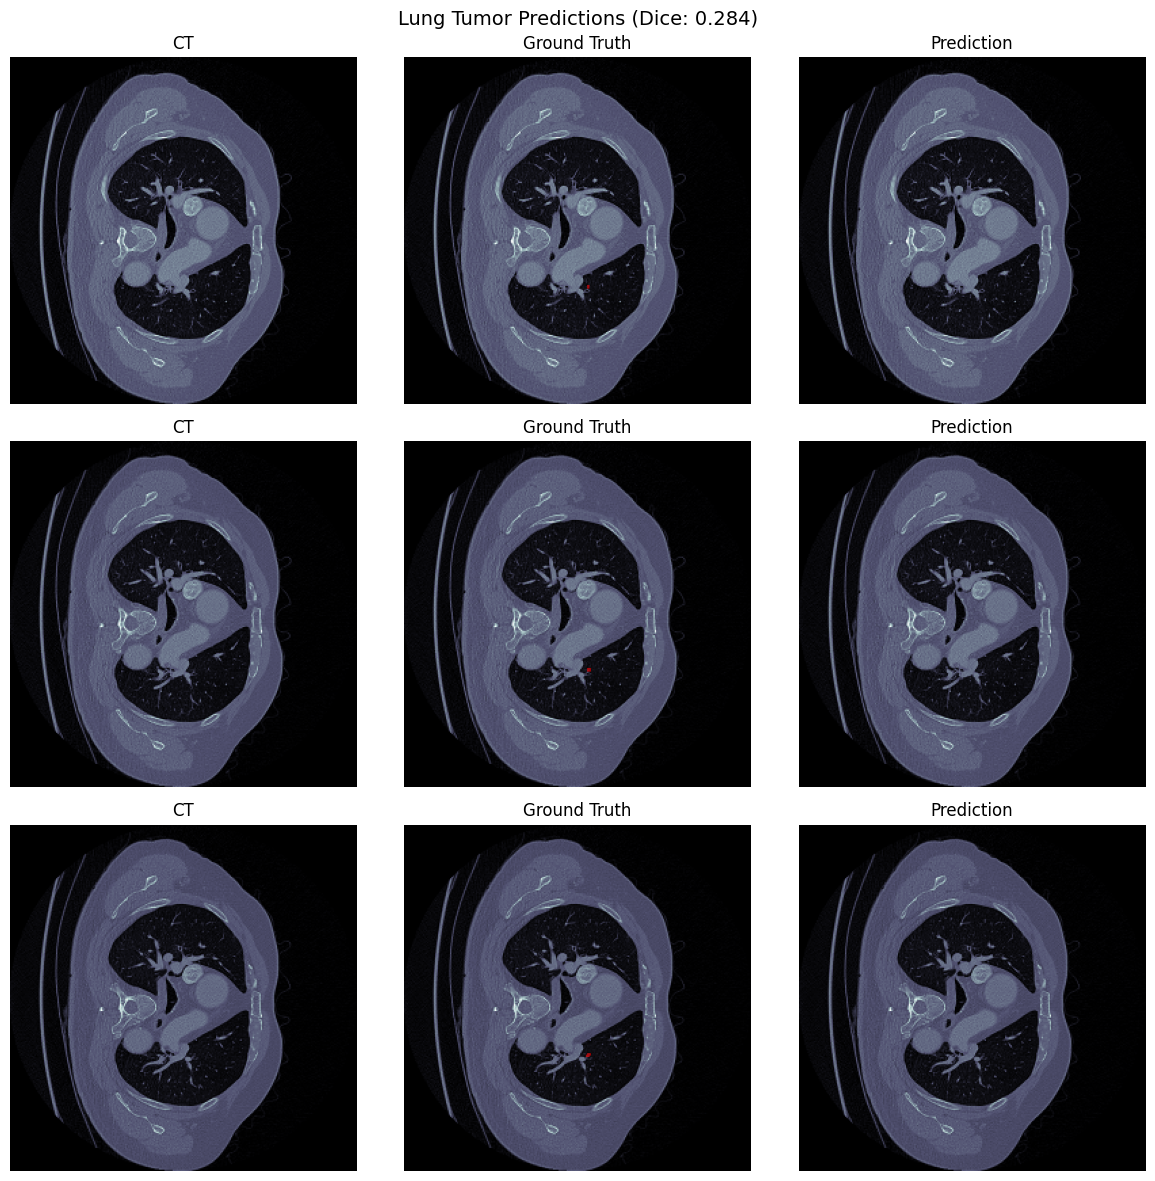

In [31]:
# Visualize predictions (find slices with tumors)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Find validation samples with tumors
tumor_indices = []
for idx in range(len(val_dataset)):
    _, mask = val_dataset[idx]
    if mask.sum() > 0:
        tumor_indices.append(idx)

for i, ax_row in enumerate(axes):
    if i < len(tumor_indices):
        idx = tumor_indices[i]
    else:
        idx = np.random.randint(0, len(val_dataset))

    image, mask = val_dataset[idx]

    with torch.no_grad():
        image_tensor = torch.tensor(image).unsqueeze(0).to(device)
        pred = model(image_tensor)[0, 0].cpu().numpy()
    pred_binary = pred > 0.5

    ax_row[0].imshow(image[0], cmap='bone')
    ax_row[0].set_title('CT')
    ax_row[0].axis('off')

    ax_row[1].imshow(image[0], cmap='bone')
    mask_gt = np.ma.masked_where(mask[0] == 0, mask[0])
    ax_row[1].imshow(mask_gt, cmap='autumn', alpha=0.6)
    ax_row[1].set_title('Ground Truth')
    ax_row[1].axis('off')

    ax_row[2].imshow(image[0], cmap='bone')
    mask_pred = np.ma.masked_where(pred_binary == 0, pred_binary)
    ax_row[2].imshow(mask_pred, cmap='autumn', alpha=0.6)
    ax_row[2].set_title('Prediction')
    ax_row[2].axis('off')

plt.suptitle(f'Lung Tumor Predictions (Dice: {dice_score:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

## Visualize Full 3D Volume

In [33]:
# Load a test subject (filter out macOS resource forks)
test_dir = DATA_ROOT / "imagesTs"
if test_dir.exists():
    test_files = sorted([f for f in test_dir.glob("*.nii.gz") if not f.name.startswith("._")])
else:
    test_files = []

if len(test_files) > 0:
    test_file = test_files[0]
else:
    test_file = sorted([f for f in IMAGES_DIR.glob("*.nii.gz") if not f.name.startswith("._")])[0]

print(f"Loading: {test_file.name}")

test_ct = nib.load(test_file).get_fdata()
test_ct = normalize_ct(test_ct)
test_ct = test_ct[:, :, 30:]  # Skip lower abdomen

print(f"Shape: {test_ct.shape}")

Loading: lung_002.nii.gz
Shape: (512, 512, 239)


In [34]:
# Predict on each slice
predictions = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(test_ct.shape[2]), desc="Predicting"):
        slice_2d = cv2.resize(test_ct[:, :, i], (256, 256))
        slice_tensor = torch.tensor(slice_2d).unsqueeze(0).unsqueeze(0).float().to(device)
        pred = model(slice_tensor)[0, 0].cpu().numpy()
        # Resize prediction back to original size
        pred_resized = cv2.resize(pred, (test_ct.shape[1], test_ct.shape[0]))
        predictions.append(pred_resized > 0.5)

Predicting:   0%|          | 0/239 [00:00<?, ?it/s]

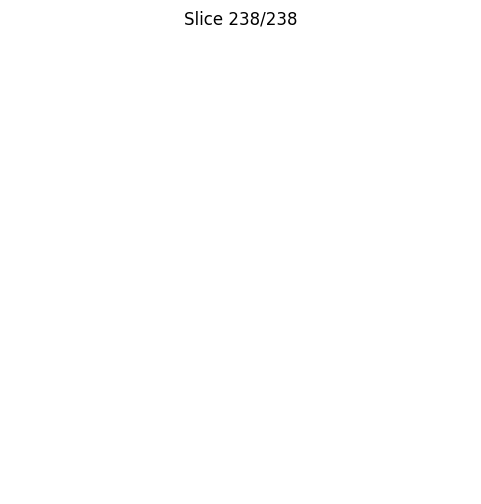

In [35]:
# Create animation
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)

for i in range(0, test_ct.shape[2], 2):  # Skip every 2nd for speed
    plt.imshow(test_ct[:, :, i], cmap='bone')
    mask = np.ma.masked_where(predictions[i] == 0, predictions[i])
    plt.imshow(mask, alpha=0.5, cmap='autumn')
    plt.title(f'Slice {i}/{test_ct.shape[2]-1}')
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

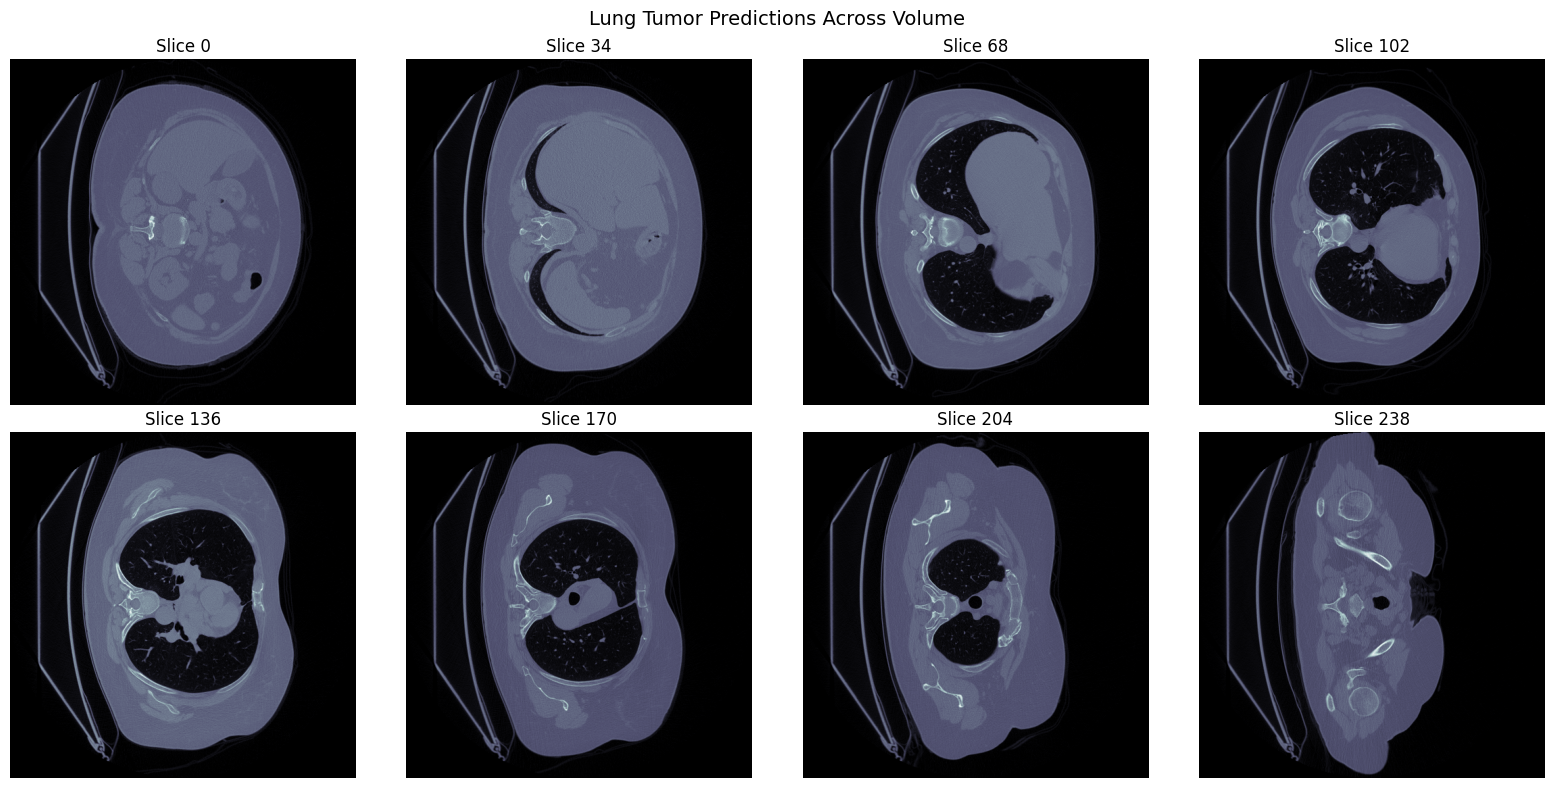

In [36]:
# Static figure for GitHub (shows key slices)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Pick slices with predictions
slice_indices = np.linspace(0, test_ct.shape[2]-1, 8).astype(int)

for idx, ax in enumerate(axes.flat):
    i = slice_indices[idx]
    ax.imshow(test_ct[:, :, i], cmap='bone')
    mask = np.ma.masked_where(predictions[i] == 0, predictions[i])
    ax.imshow(mask, alpha=0.5, cmap='autumn')
    ax.set_title(f'Slice {i}')
    ax.axis('off')

plt.suptitle('Lung Tumor Predictions Across Volume', fontsize=14)
plt.tight_layout()
plt.show()

---
# Summary

## What We Covered

| Topic | Key Points |
|-------|------------|
| **CT vs MRI** | Fixed HU range → simpler normalization |
| **Class Imbalance** | WeightedRandomSampler upweights rare tumors |
| **BCE vs Dice** | BCE more stable for tiny objects |
| **U-Net** | Same architecture, different modality |

## Portfolio Summary

You now have:

| Notebook | Task | Modality | Key Techniques |
|----------|------|----------|----------------|
| Pneumonia | Classification | Chest X-ray | Transfer learning, CAM |
| Atrium | Segmentation | Cardiac MRI | U-Net, Dice loss |
| Lung Tumor | Segmentation | Chest CT | Weighted sampling, BCE |

This covers 2D/3D, classification/segmentation, MRI/CT